In [66]:
import numpy as np
import pandas as pd
import cv2
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [67]:
# Read data
df = pd.read_csv("C:/Users/ebruc/Desktop/ODIR-5K/full_df.csv")

In [68]:
# Define function to check for cataract
def has_cataract(text):
    return 1 if "cataract" in text else 0


In [69]:
# Apply cataract check to dataframe
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(has_cataract)
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(has_cataract)


In [70]:
# Filter cataract and normal images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250, random_state=42).values


In [71]:
# Combine cataract and normal images
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)


In [72]:
# Data directory
dataset_dir = "C:/Users/ebruc/Desktop/ODIR-5K/preprocessed_images/"
image_size = 224


In [73]:
# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [74]:
# Define a function to create dataset with augmentation
def create_augmented_dataset(image_category, label):
    augmented_dataset = []
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            image = np.expand_dims(image, axis=0)
            augmented_images = datagen.flow(image, batch_size=1)
            for batch in augmented_images:
                augmented_dataset.append([batch[0], label])
                break  # Otherwise the generator loops indefinitely
        except:
            continue
    random.shuffle(augmented_dataset)
    return augmented_dataset


In [75]:
# Create augmented datasets
augmented_cataract = create_augmented_dataset(cataract, 1)
augmented_normal = create_augmented_dataset(normal, 0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.61it/s]


In [76]:
# Concatenate augmented datasets
augmented_dataset = augmented_cataract + augmented_normal
random.shuffle(augmented_dataset)

In [77]:
# Split dataset into features and labels
x = np.array([i[0] for i in augmented_dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in augmented_dataset])


In [78]:
# Split data into train and test sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.05)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.10)

In [79]:
x_test.shape[0]

55

In [80]:
# Load pre-trained VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
for layer in vgg.layers:
    layer.trainable = False


In [81]:
# Build model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))


In [82]:
# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [83]:
# Define callbacks
checkpoint = ModelCheckpoint("vgg19_augmented.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_fleq='epoch')

In [84]:
# Train model
history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val), verbose=1, callbacks=[checkpoint])


Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 1.8252 - accuracy: 0.8730
Epoch 1: val_accuracy improved from -inf to 0.94231, saving model to vgg19_augmented.h5
30/30 [==============================] - 150s 5s/step - loss: 1.8252 - accuracy: 0.8730 - val_loss: 1.5874 - val_accuracy: 0.9423
Epoch 2/15


C:\Users\ebruc\Desktop\Python\pythonProject\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.9386
Epoch 2: val_accuracy did not improve from 0.94231
30/30 [==============================] - 163s 5s/step - loss: 0.6491 - accuracy: 0.9386 - val_loss: 1.1889 - val_accuracy: 0.8942
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9742
Epoch 3: val_accuracy did not improve from 0.94231
30/30 [==============================] - 156s 5s/step - loss: 0.2012 - accuracy: 0.9742 - val_loss: 0.8628 - val_accuracy: 0.9231
Epoch 4/15
30/30 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9935
Epoch 4: val_accuracy did not improve from 0.94231
30/30 [==============================] - 146s 5s/step - loss: 0.0320 - accuracy: 0.9935 - val_loss: 0.8725 - val_accuracy: 0.9231
Epoch 5/15
30/30 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9946
Epoch 5: val_accuracy did not improve from 0.94231
30/30 [==============================] - 

KeyboardInterrupt: 

In [57]:
# Evaluate model
loss, accuracy = model.evaluate(x_val, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)

7/7 [==============================] - 28s 4s/step - loss: 1.2418 - accuracy: 0.9174
Loss: 1.2417569160461426
Accuracy: 0.9174311757087708


In [58]:
# Make predictions
y_pred = (model.predict(x_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))


7/7 [==============================] - 31s 4s/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        97
           1       0.95      0.90      0.92       121

    accuracy                           0.92       218
   macro avg       0.92      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

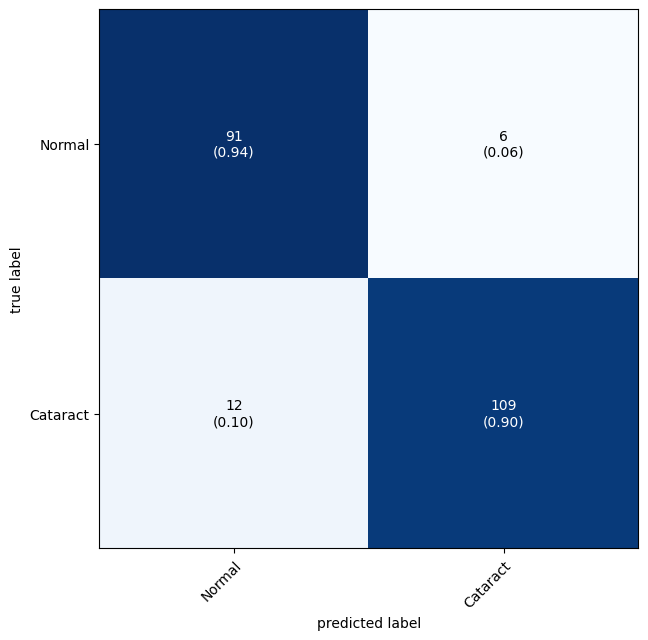

In [59]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Cataract"], show_normed=True)


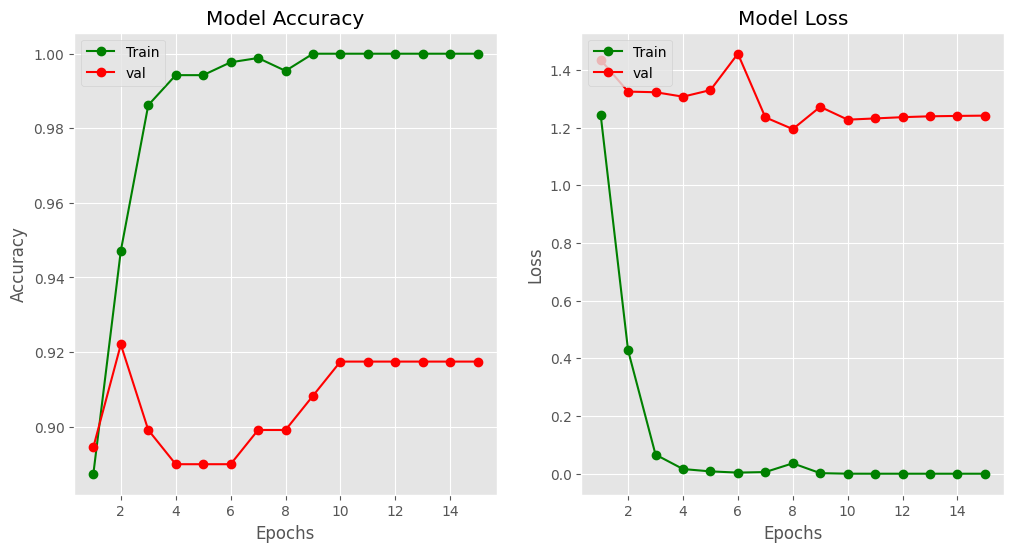

In [60]:
# Plot training history
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))
epochs = range(1, 16)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "val"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "val"], loc="upper left")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

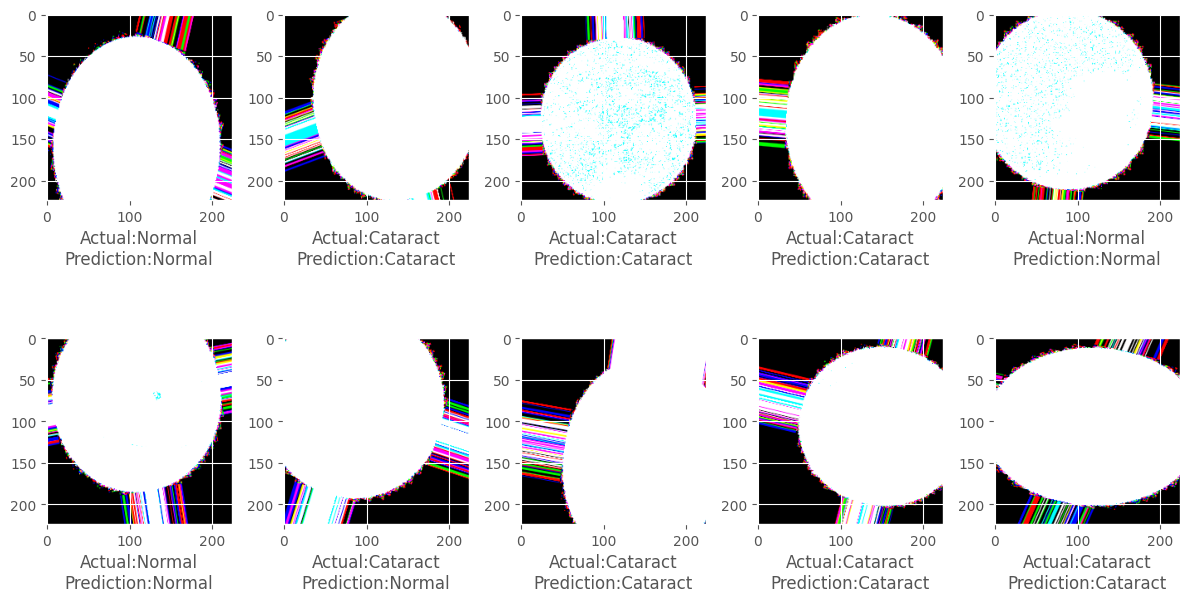

In [62]:
# Visualize predictions
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    label = "Normal" if category == 0 else "Cataract"
    pred_label = "Normal" if pred_category == 0 else "Cataract"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label, pred_label))
plt.tight_layout()
plt.show()